In [2]:
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
rng = np.random.default_rng()


In [3]:
%%bash
slim -s 119 -d R0=10 -d 'OUTPUT="bearded_seal_parents.csv"' -d 'POPSIZE_FILE="bearded_seal_popsize.csv"' bearded_seals/bearded_seals.slim

// Initial random seed:
119

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
22026
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.56419, sexSegregation="FM");
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 



In [4]:
parents = pd.read_csv("bearded_seal_parents.csv")

### Define a sampling intensity grid and sample from dead animals for each year according to the grid

In [5]:
# Divide into years
sample_year = 41
sample_parents = parents.loc[parents.sampling_time == sample_year]

In [6]:
def sample_cell(sample_parents, xmin, xmax, ymin, ymax, nmax):
    # Sample from individuals within one grid cell
    in_i = np.where(np.logical_and(np.logical_and(sample_parents.loc[:,'x'] <= xmax, sample_parents.loc[:,'x'] >= xmin),
                np.logical_and(sample_parents.loc[:,'y'] >= ymin, sample_parents.loc[:,'y'] <= ymax)))[0]
    # Sample size is nmax or the number of individuals in the area
    ss = min(len(in_i), nmax)
    sample_rows = rng.choice(in_i, ss, replace = False)
    return(ss, sample_rows)

In [7]:
def sample_grid(individuals, sampling_intensity, n, width = 10, height = 10):
    # Sample from each grid cell
    # Sample size 
    ss = np.array(np.ceil(n*sampling_intensity/np.sum(sampling_intensity)), dtype = int)
    # Keep track of actual sample sizes (since if there are fewer than ss individuals in a grid cell, all are sampled)
    realized_ss = np.zeros(ss.shape, dtype = int)
    
    # Width and height of grid cells
    x_cells = ss.shape[0]
    y_cells = ss.shape[1]
    dx = width/x_cells
    dy = height/y_cells
    
    # Keep track of sampled rows
    #sample_rows = np.empty(round(np.sum(ss)), dtype = int)
    sample_rows = np.empty(0, dtype = int)
    # Sample from each grid cell
    for ix, iy in np.ndindex(ss.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        nmax = ss[ix, iy]
        realized_ss[ix, iy], grid_rows = sample_cell(individuals, xmin, xmax, ymin, ymax, nmax)
        sample_rows = np.concatenate([sample_rows, grid_rows])
    return(realized_ss, sample_rows)

### Make plots of sample

In [8]:
def make_spaghetti(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    spaghetti = Image.new("1", (w, h))
    img1 = ImageDraw.Draw(spaghetti)

    # Find individuals with a parent that is in the sample
    p_in_i = np.isin(sample_parents.loc[:,'parent1'], sample_parents.loc[:,'individual'])
    npairs = sum(p_in_i)

    # Get location of parent-offspring pairs and plot
    children = sample_parents.loc[p_in_i, :]
    for child_i, child_row in children.iterrows():
        parent_i = np.where(sample_parents.loc[:,'individual'] == child_row['parent1'])[0][0]
        parent_row = sample_parents.iloc[parent_i,:]
        # print(parent_row['individual'], child_row['individual'])
        x_child, y_child = child_row[['x','y']]
        x_parent, y_parent = parent_row[['x','y']]
        img1.line([(x_child*w/max_width, y_child*h/max_height), (x_parent*w/max_width, y_parent*h/max_height)], fill ="white", width = 0)

    return(spaghetti)

In [9]:
def plot_samples(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    sampling = Image.new("1", (w, h))
    img2 = ImageDraw.Draw(sampling)

    # Plot sampling
    for ind_i, ind_row in sample_parents.iterrows():
        x, y = ind_row[['x','y']]
        img2.point((x*w/max_width, y*h/max_height), fill = "white")
    return(sampling)

In [10]:
def plot_intensity(sampling_intensity, image_w, image_h):
    w, h = image_w, image_h
    intensity = Image.new("L", (w, h))
    img3 = ImageDraw.Draw(intensity)

    # Width and height of grid cells
    x_cells = sampling_intensity.shape[0]
    y_cells = sampling_intensity.shape[1]
    dx = w/x_cells
    dy = h/y_cells
    # Maximum sampling intensity (will be 255 or all white)
    max_int = np.max(sampling_intensity)
    # Plot sampling intensity
    for ix, iy in np.ndindex(sampling_intensity.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        # Sampling
        rel_intensity = round(255*sampling_intensity[ix, iy]/max_int)
        img3.rectangle([(xmin, ymin), (xmax, ymax)], fill = rel_intensity, outline=None, width=0)
    return(intensity)

In [11]:
sampling_intensity =  np.ones((10,10))*np.linspace(1, 5, 10)
ss, sample_rows = sample_grid(parents, sampling_intensity, 1000, 10, 10)
print(ss)
sample = parents.iloc[sample_rows]

[[ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]
 [ 4  5  7  8 10 11 13 14 16 17]]


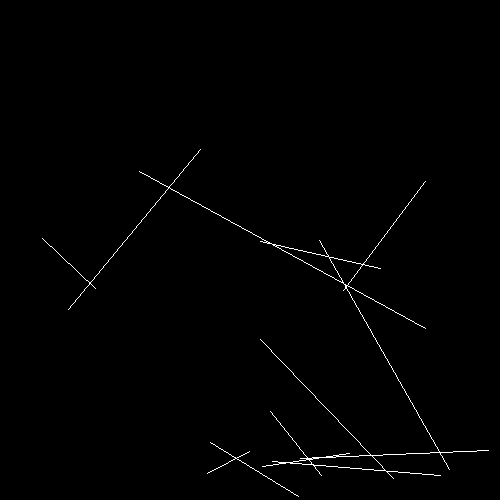

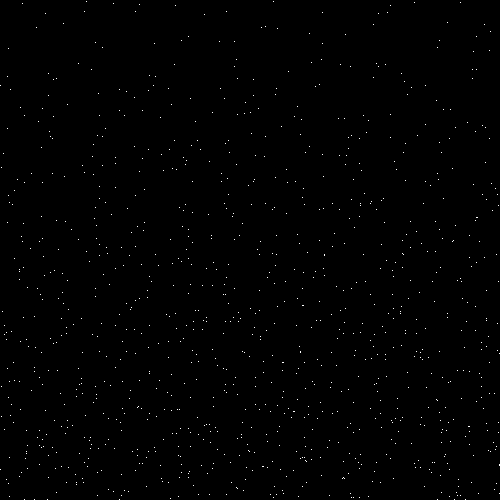

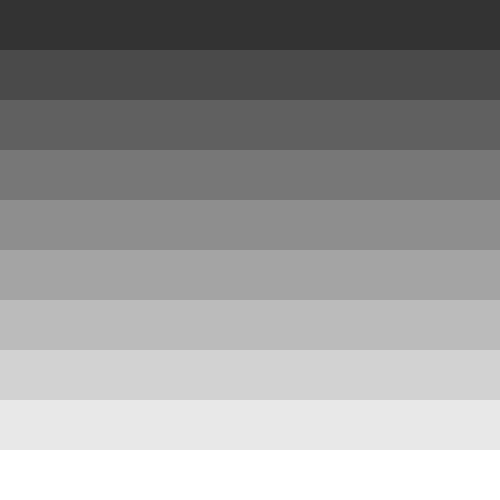

In [12]:
display(make_spaghetti(sample, 500, 500, 10, 10))
display(plot_samples(sample, 500, 500, 10, 10))
display(plot_intensity(sampling_intensity, 500, 500))

In [13]:
popsize = pd.read_csv("bearded_seal_popsize.csv")

In [14]:
print(popsize)
print(popsize.columns)
np.mean(popsize.loc[:,'N'])

    sampling_time      N
0              40  18013
1              41  17995
2              42  17997
3              43  17923
4              44  17772
5              45  17693
6              46  17630
7              47  17459
8              48  17398
9              49  17354
10             50  17397
11             51  17438
12             52  17391
13             53  17305
14             54  17267
15             55  17206
16             56  17111
17             57  17026
18             58  16936
19             59  16951
20             60  16873
Index(['sampling_time', 'N'], dtype='object')


17435.0

In [16]:
np.sum(ss)

1050